In [1]:
import os
import sys
import time
import glob

# dependencies that come with Openpilot
import numpy as np
import scipy
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm

# separate dependencies
import imageio

# Openpilot, Openpilot Tools and Laika
from common.transformations.camera import img_from_device, denormalize
from tools.lib.logreader import LogReader
from tools.lib.framereader import FrameReader, FrameIterator
import laika.lib.coordinates as coord
import laika.lib.orientation as orient

In [2]:
DATA_BASE_DIR = '/data/realdata/aba20ae4/'

In [3]:
def for_each_segment(func, **kwargs):
    '''Call `func` on each segment.'''
    segment_dirs = glob.glob(os.path.join(DATA_BASE_DIR, '*/*/2021-*-*--*-*-*/'))
    segment_dirs = sorted(segment_dirs, key=lambda p: os.path.basename(os.path.dirname(p)))

    for base_dir in segment_dirs:
        parts = sorted(set(os.listdir(base_dir)) - set(['qcamera.m3u8']), key=lambda p: int(p))
        parts = [os.path.join(base_dir, part) for part in parts]
        for part in parts:
            func(part, **kwargs)

In [4]:
def read_poses(segment_dir, logfile='rlog.bz2'):
    logs = LogReader(os.path.join(segment_dir, logfile))
    
    kalman_msgs = [m.liveLocationKalman for m in logs if m.which() == 'liveLocationKalman']
    
    poses = {
        'positions_ecef': np.array([m.positionECEF.value for m in kalman_msgs]),
        'velocities_calib': np.array([m.velocityCalibrated.value for m in kalman_msgs]),
        'velocities_ecef': np.array([m.velocityECEF.value for m in kalman_msgs]),
        'accelerations_calib': np.array([m.accelerationCalibrated.value for m in kalman_msgs]),
        'accelerations_device': np.array([m.accelerationDevice.value for m in kalman_msgs]),
        'orientations_calib': np.array([m.calibratedOrientationECEF.value for m in kalman_msgs]),
        'orientations_ecef': np.array([m.orientationECEF.value for m in kalman_msgs]),
        'angular_velocities_calib': np.array([m.angularVelocityCalibrated.value for m in kalman_msgs]),
        'angular_velocities_device': np.array([m.angularVelocityDevice.value for m in kalman_msgs]),
        'times': np.array([m.unixTimestampMillis for m in kalman_msgs]),
    }
    if len(poses['orientations_ecef']) > 0:
        poses['orientations_euler'] = orient.euler2quat(poses['orientations_ecef'])

    status = {
        'positions': np.array([m.positionECEF.valid for m in kalman_msgs]),
        'velocities': np.array([m.velocityECEF.valid for m in kalman_msgs]),
        'accelerations': np.array([m.accelerationCalibrated.valid for m in kalman_msgs]),
        'orientations_calib': np.array([m.calibratedOrientationECEF.valid for m in kalman_msgs]),
        'angular_velocities_calib': np.array([m.angularVelocityCalibrated.valid for m in kalman_msgs]),
        'status': np.array([m.status for m in kalman_msgs]),
        'inputsOK': np.array([m.inputsOK for m in kalman_msgs]),
        'posenetOK': np.array([m.posenetOK for m in kalman_msgs]),
        'gpsOK': np.array([m.gpsOK for m in kalman_msgs]),
        'sensorsOK': np.array([m.sensorsOK for m in kalman_msgs]),
        'deviceStable': np.array([m.deviceStable for m in kalman_msgs]),
        'excessiveResets': np.array([m.excessiveResets for m in kalman_msgs]),
    }
        
    return poses, status


def is_valid_segment(statuses):
    checks = {
        'gpsOK': np.all(statuses['gpsOK'] == True),
        'sensorsOK': np.all(statuses['sensorsOK'] == True),
        'inputsOK': np.all(statuses['inputsOK'] == True),
        'deviceStable': np.all(statuses['deviceStable'] == True),
        'positionsValid': np.all(statuses['positions'] == True),
        'velocitiesValid': np.all(statuses['velocities'] == True),
        'orientations_calibValid': np.all(statuses['orientations_calib'] == True),
        'angular_velocities_calibValid': np.all(statuses['angular_velocities_calib'] == True),
        'allValid': np.all([str(i) == 'valid' for i in statuses['status']]),
        'notEmpty': len(statuses['status'] > 0)
    }
    all_good = np.all(list(checks.values()))
    
    if not all_good:
        for check, value in checks.items():
            if not value:
                print(f'FAILED {check}.', end=' ')
    
    return all_good


def save_segment_poses(segment_path, output_file='ground_truths.npz'):
    print(f'Segment {"/".join(segment_path.split("/")[-2:])}', end=' ')
    try:
        poses, statuses = read_poses(segment_path)
    except:
        print('Failed to read logs. Skipping segment.')
        return
    
    if not is_valid_segment(statuses): 
        print('Skipping segment.')        
        return
    
    ecef_positions = poses['positions_ecef']
    euler_orientations = poses['orientations_euler']
    
    local_positions = []
    
    
    for i in range(0, len(poses['positions_ecef'])):
        ecef_from_local = orient.rot_from_quat(euler_orientations[i])
        local_from_ecef = ecef_from_local.T
        frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, ecef_positions - ecef_positions[i])
        
        if len(frame_positions_local) != 1200:
            print(f'Read only {len(frame_positions_local)} positions. Skipping segment.')
            return
        
        local_positions.append(frame_positions_local)
            
    poses['positions_device'] = np.array(local_positions)
    
    print(f'ALL GOOD')
    np.savez_compressed(os.path.join(segment_path, output_file), **poses)  


In [5]:
def compress_frame(frame):
    img = Image.fromarray((frame * 255).astype(np.uint8))
    new_size = (img.size[0]//3, img.size[1]//3)
    img = img.resize(new_size, Image.LANCZOS)        
    return np.array(img)
   

def save2gif(filenames, out='test.gif'):
    with imageio.get_writer(out, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(compress_frame(image))

In [6]:
def get_poses(segment_path, kind='liveKalman'):
    if kind == 'liveKalman':
        poses, statuses = read_poses(example_segment)
        frame_positions = poses['positions_ecef']
        frame_orientations_ecef = poses['orientations_calib']
        frame_orientations = orient.euler2quat(frame_orientations_ecef)
    elif kind == 'comma2k19':
        frame_positions = np.load(example_segment + 'global_pose/frame_positions')
        frame_orientations = np.load(example_segment + 'global_pose/frame_orientations')
    elif kind == 'laika':
        raise NotImplementedError('laika')
    
    return frame_positions, frame_orientations


def draw_path(device_path, img, width=1, height=1.2, fill_color=(128,0,255), line_color=(0,255,0)):
    device_path_l = device_path + np.array([0, 0, height])                                                                    
    device_path_r = device_path + np.array([0, 0, height])                                                                    
    device_path_l[:,1] -= width                                                                                               
    device_path_r[:,1] += width

    img_points_norm_l = img_from_device(device_path_l)
    img_points_norm_r = img_from_device(device_path_r)
    img_pts_l = denormalize(img_points_norm_l)
    img_pts_r = denormalize(img_points_norm_r)

    # filter out things rejected along the way
    valid = np.logical_and(np.isfinite(img_pts_l).all(axis=1), np.isfinite(img_pts_r).all(axis=1))
    img_pts_l = img_pts_l[valid].astype(int)
    img_pts_r = img_pts_r[valid].astype(int)

    for i in range(1, len(img_pts_l)):
        u1,v1,u2,v2 = np.append(img_pts_l[i-1], img_pts_r[i-1])
        u3,v3,u4,v4 = np.append(img_pts_l[i], img_pts_r[i])
        pts = np.array([[u1,v1],[u2,v2],[u4,v4],[u3,v3]], np.int32).reshape((-1,1,2))
        cv2.fillPoly(img,[pts],fill_color)
        cv2.polylines(img,[pts],True,line_color)


def create_pose_gif(segment_path, output_file='path.gif', pix_fmt = 'rgb24', force=False):
    print('Segment:', os.path.join(os.path.basename(os.path.dirname(segment_path))), os.path.basename(segment_path))
    gt_file = os.path.join(segment_path, 'ground_truths.npz')
    already_processed = False
    
    if os.path.exists(gt_file):
        already_processed = True
        gts = np.load(gt_file)
        frame_positions = gts['positions_device']
    elif force:
        frame_positions, frame_orientations = get_poses(segment_path)
    else:
        print('No GT found:', segment_path)
        return

    fr = FrameReader(os.path.join(segment_path, 'fcamera.hevc'))

    with imageio.get_writer(os.path.join(segment_path, output_file), mode='I') as writer:

        for i in tqdm(range(0, fr.frame_count, 1*20)):
            frame = fr.get(i, pix_fmt=pix_fmt)[0]
            img = np.copy(frame)
            img = (img + 1e-12) / 255.

            if already_processed:
                frame_positions_local = frame_positions[i]
            else:
                ecef_from_local = orient.rot_from_quat(frame_orientations[i])
                local_from_ecef = ecef_from_local.T
                frame_positions_local = np.einsum('ij,kj->ki', local_from_ecef, frame_positions - frame_positions[i])  

            draw_path(frame_positions_local[i+1:i+250], img)
            img = np.clip(img, 0, 1)
            
            writer.append_data(compress_frame(img))

# Save poses for all Lexus history

In [ ]:
for_each_segment(save_segment_poses)
# for_each_segment(create_pose_gif)

# Example of usage

In [12]:
segment_path = '/data/realdata/aba20ae4/06b5d227e8d0f0a632c4d0a7bd9e8f6e305ed1910848cd5597eecdfe8e6d0023/1b9935697c8f4671ca355e2acd851d99e249c50c9948256972c4b6b4b045fc8f/2021-09-14--09-19-21/8/'

ground_truths = np.load(os.path.join(segment_path, 'ground_truths.npz'))

In [8]:
list(ground_truths.keys())

['positions_ecef',
 'velocities_calib',
 'velocities_ecef',
 'accelerations_calib',
 'accelerations_device',
 'orientations_calib',
 'orientations_ecef',
 'angular_velocities_calib',
 'angular_velocities_device',
 'times',
 'orientations_euler',
 'positions_device']

In [9]:
print(ground_truths['positions_device'].shape)
print(ground_truths['orientations_euler'].shape)                    

(1200, 1200, 3)
(1200, 4)


# Formatting ground truths for training

In [ ]:
# T_IDXS and X_IDXS taken from:
# https://github.com/commaai/openpilot/blob/a7f36c9daf65f0642aa395c07c140d82bc2a7a1e/selfdrive/common/modeldata.h

T_IDXS = [0.        ,  0.00976562,  0.0390625 ,  0.08789062,  0.15625   ,
        0.24414062,  0.3515625 ,  0.47851562,  0.625     ,  0.79101562,
        0.9765625 ,  1.18164062,  1.40625   ,  1.65039062,  1.9140625 ,
        2.19726562,  2.5       ,  2.82226562,  3.1640625 ,  3.52539062,
        3.90625   ,  4.30664062,  4.7265625 ,  5.16601562,  5.625     ,
        6.10351562,  6.6015625 ,  7.11914062,  7.65625   ,  8.21289062,
        8.7890625 ,  9.38476562, 10.]

X_IDXS = [
         0.    ,   0.1875,   0.75  ,   1.6875,   3.    ,   4.6875,
         6.75  ,   9.1875,  12.    ,  15.1875,  18.75  ,  22.6875,
        27.    ,  31.6875,  36.75  ,  42.1875,  48.    ,  54.1875,
        60.75  ,  67.6875,  75.    ,  82.6875,  90.75  ,  99.1875,
       108.    , 117.1875, 126.75  , 136.6875, 147.    , 157.6875,
       168.75  , 180.1875, 192.]

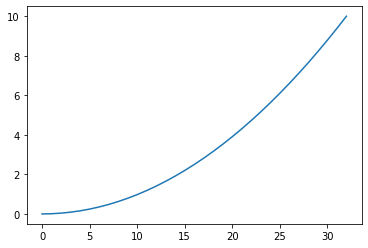

In [189]:
plt.plot(T_IDXS)

In [188]:
def format_segment_plans_gt(ground_truths):
    '''Convert segment's path to a format suitable for NN training.
    
    Uses this format: https://github.com/commaai/openpilot/blob/eaaccaa3d82f2cff0a4c78014f798edc476886a5/models/README.md
    
    Return: [B, 1, 33, 15]     B - batch dimension, which can vary.
    '''
    plans_gt = []

    for step in tqdm(range(0, len(ground_truths['positions_device']))):

        times = ground_truths['times']/1000
        times_rel = times - times[step]
        times_rel

        future_steps = []

        t_idx = 0

        for idx, t in enumerate(times_rel):
            if t_idx >= len(T_IDXS): break
            if t >= T_IDXS[t_idx]:
                future_steps.append(idx)
                t_idx +=1

        if len(future_steps) < 33:
            break

        positions = ground_truths['positions_device'][step][future_steps] # maybe should calibrate?
        velocities = ground_truths['velocities_calib'][future_steps]
        accelerations = ground_truths['accelerations_calib'][future_steps]
        orientations = ground_truths['orientations_calib'][future_steps]
        orientation_rates = ground_truths['angular_velocities_calib'][future_steps]
        
        plan = np.hstack([positions, velocities, accelerations, orientations, orientation_rates]) # (33, 15)
        plan = np.expand_dims(plan, 0) # (1, 33, 15)
        plans_gt.append(plan)

    return np.stack(plans_gt) # (1000, 1, 33, 15)

In [186]:
plans_gt = format_segment_plans_gt(ground_truths)
plans_gt.shape

(1000, 1, 33, 15)

In [184]:
# Plan for a future 20th step at t=100
print(plans_gt[100, 0, 20, 0:3], 'x,y,z position')
print(plans_gt[100, 0, 20, 3:6], 'x,y,z velocity')
print(plans_gt[100, 0, 20, 6:9], 'x,y,z acceleration')
print(plans_gt[100, 0, 20, 9:12], 'raw,pitch,yaw')
print(plans_gt[100, 0, 20, 12:15], 'raw,pitch,yaw rate')

[51.68832393 -2.041938   -3.01289854] x,y,z position
[12.8582997   0.02553609 -0.40659708] x,y,z velocity
[ 0.07485709 -0.00094826 -0.13331131] x,y,z acceleration
[-2.88844558 -0.49680533 -3.09160612] raw,pitch,yaw
[ 0.01039961  0.0074509  -0.01146076] raw,pitch,yaw rate
